<a href="https://colab.research.google.com/github/jtayar/APOGEEs_Galaxy_AST4300/blob/main/Project3_AST4300_PaperPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#Import some things
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord

In [9]:
#load in the data (may have to change this for wherever you downloaded your file)
filename='allStarLite-dr17-synspec_rev1.fits'
!wget https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits
tb = fits.open(filename)
header=tb[1].header
data = tb[1].data

--2023-12-12 00:14:24--  https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1834963200 (1.7G) [application/octet-stream]
Saving to: ‘allStarLite-dr17-synspec_rev1.fits.1’

allStarLite-dr17-sy 100%[===================>]   1.71G  27.6MB/s    in 62s     

2023-12-12 00:15:26 (28.4 MB/s) - ‘allStarLite-dr17-synspec_rev1.fits.1’ saved [1834963200/1834963200]



In [8]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [10]:
#Answer:
print('Answer: There are '+str(len(data))+' targets in DR17')

Answer: There are 733901 targets in DR17


In [11]:
#print(header)

In [12]:
# get rid of stars with negative distances
mask_gaia = (data['GAIAEDR3_PARALLAX']>0)

# use skycoord to input information
c = SkyCoord(ra=data['RA'][mask_gaia]*u.deg, dec=data['DEC'][mask_gaia]*u.deg,
             distance=(data['GAIAEDR3_R_MED_GEO'][mask_gaia])*u.kpc,
             pm_ra_cosdec=data['GAIAEDR3_PMRA'][mask_gaia]*u.mas/u.yr,
             pm_dec=data['GAIAEDR3_PMDEC'][mask_gaia]*u.mas/u.yr,
            radial_velocity=data['RV_CCFWHM'][mask_gaia]*u.km/u.s) #dunno where the APOGEE RVs are

# transform to galactocentric coordinate
# the assumed values are from Schonrich et al 2010, and from Gravity collab 2022
galcen = c.transform_to(coord.Galactocentric(galcen_v_sun=[8, 254, 8] * u.km / u.s, galcen_distance=8.275 * u.kpc))


In [13]:
# Extract the galactic coordinates and motions
x = galcen.x.value
y = galcen.y.value
z = galcen.z.value

vx = galcen.v_x.value
vy = galcen.v_y.value
vz = galcen.v_z.value

#galactocentric radius (either in the disk-R or distance from the galactic center)
R = np.sqrt(x**2+y**2)
rgal = np.sqrt(x**2+y**2+z**2)

In [15]:
#I clipped data table, including the the M/H and alpha/M vectors to the same length as the R and z information first before plotting
data_masked=data[mask_gaia]


In [16]:
#Read in file
agefilename='APOKASC705_AGE_short.fits'
agetb = fits.open(agefilename)
ageheader=agetb[1].header[0:14]
agedata = agetb[1].data
#put the ages in an array
ages=agedata['AGE_JT']
apogeeidAge=agedata['APOGEE_ID']
#print the header
print(ageheader)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   44 / length of dimension 1                          NAXIS2  =                11823 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    3 / number of table fields                         TTYPE1  = 'KEPLER_ID'                                                           TFORM1  = '20A     '                                                            TTYPE2  = 'APOGEE_ID'                                                           TFORM2  = '20A     '                                                            TTYPE3  = 'AGE_JT  '                    

In [17]:
#Answer:
print('Answer: There are '+str(len(agedata))+' targets with ages')

Answer: There are 11823 targets with ages


In [18]:
#Figure out which stars are in both lists and what their array elements are
intersect, ind_a, ind_b = np.intersect1d(data_masked['APOGEE_ID'],agedata['APOGEE_ID'], return_indices=True)
print(len(ind_b))

11813


In [19]:
from tensorflow import keras

In [20]:
fullx = np.dstack([data_masked['TEFF'][ind_a],data_masked['LOGG'][ind_a], data_masked['M_H'][ind_a],
                   data_masked['C_FE'][ind_a], data_masked['N_FE'][ind_a]])[0]
fully = np.dstack([agedata['AGE_JT'][ind_b]])[0]

#remove non-finite entries!
mask = np.all(np.isfinite(fullx), axis=1) & np.all(np.isfinite(fully), axis=1)
fullx, fully = fullx[mask], fully[mask]

scaling_x = np.median(fullx, axis=0)
scaling_y = np.median(fully, axis=0)

fullx, fully = fullx/scaling_x, fully/scaling_y

In [55]:
# my numbers are
neurons_per_layer=1000
layers=6
iterations=20

In [56]:

#start with an input layer
inputs = keras.Input(shape=(5,))
#now we add the Dense layers (indicating the previous layer in the brackets following the layer declaration

#change this part if you're changing the number of layers
layer1 =keras.layers.Dense(neurons_per_layer, activation='relu')(inputs)
layer2 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer1)
layer3 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer2)
layer4 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer3)
layer5 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer4)
layer6 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer5)
layer7 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer6)
layer8 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer7)
#layer9 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer8)
#layer10 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer9)
#layer11 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer10)
#layer12 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer11)
#layer13 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer12)
#layer14 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer13)
#layer15 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer14)
#layer16 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer15)
#layer17 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer16)
#layer18 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer17)
#layer19 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer18)
#layer20 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer19)
#layer21 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer20)
#layer22 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer21)
#layer23 = keras.layers.Dense(neurons_per_layer, activation='relu')(layer22)
#then the output layer
outputs = keras.layers.Dense(1)(layer6)


# then we put that all together in the Model object
model = keras.Model(inputs=inputs, outputs=outputs, name='test')
#and we can print a summary to check it all went to plan
model.summary()

Model: "test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_27 (Dense)            (None, 1000)              6000      
                                                                 
 dense_28 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_29 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_30 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_31 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_32 (Dense)            (None, 1000)              1001000

In [57]:

model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

In [58]:
#last name before M
#trainbin=slice(0,-2002)
#testing=slice(-2001,-1)


#last name M or later
trainbin=slice(2001,-1)
testing=slice(0,2000)


x_train, y_train = fullx[trainbin], fully[trainbin]
x_test, y_test = fullx[testing], fully[testing]

In [59]:
model.fit(x_train, y_train, epochs=iterations,validation_split=0.05, batch_size=300)

Epoch 1/20
31/31 [==============================] - 9s 235ms/step - loss: 2.4014 - accuracy: 1.0767e-04 - val_loss: 1.6281 - val_accuracy: 0.0000e+00
Epoch 2/20
31/31 [==============================] - 12s 378ms/step - loss: 1.4389 - accuracy: 1.0767e-04 - val_loss: 1.6267 - val_accuracy: 0.0000e+00
Epoch 3/20
31/31 [==============================] - 10s 314ms/step - loss: 1.3621 - accuracy: 1.0767e-04 - val_loss: 1.6406 - val_accuracy: 0.0000e+00
Epoch 4/20
31/31 [==============================] - 7s 225ms/step - loss: 1.3378 - accuracy: 1.0767e-04 - val_loss: 1.6655 - val_accuracy: 0.0000e+00
Epoch 5/20
31/31 [==============================] - 9s 292ms/step - loss: 1.3191 - accuracy: 1.0767e-04 - val_loss: 1.6381 - val_accuracy: 0.0000e+00
Epoch 6/20
31/31 [==============================] - 7s 225ms/step - loss: 1.2989 - accuracy: 1.0767e-04 - val_loss: 1.6234 - val_accuracy: 0.0000e+00
Epoch 7/20
31/31 [==============================] - 9s 290ms/step - loss: 1.2782 - accuracy: 1.076

In [60]:
predictions = model.predict(x_test)
print(len(predictions))

63/63 [==============================] - 2s 23ms/step
2000


In [61]:
metric=0.3 #is the accuracy better than 30%?
goodfit=np.where(((1-metric) < predictions/y_test) & ((1+metric) > predictions/y_test))
badfit=np.where(((1-metric) > predictions/y_test) | ((1+metric) < predictions/y_test))

print ('With ', neurons_per_layer, 'neurons per layer, ', layers, 'layers, and ', iterations, 'iterations')
print ('using the training set', trainbin)
print (len(goodfit[0])/len(y_test)*100, 'percent of the ages are good')
print (len(badfit[0])/len(y_test)*100, 'percent of the ages are bad')

With  1000 neurons per layer,  6 layers, and  20 iterations
using the training set slice(2001, -1, None)
55.65 percent of the ages are good
44.35 percent of the ages are bad


Text(1, 12, 'Overfit')

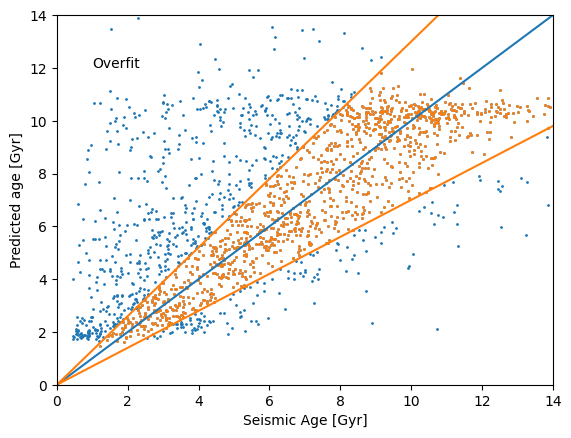

In [62]:
#remember that we scaled our input/output
plt.scatter( (y_test*scaling_y),(predictions*scaling_y), s=1.)
plt.scatter( (y_test[goodfit]*scaling_y),(predictions[goodfit]*scaling_y), s=1.)
plt.xlim(0.,14.)
plt.plot([0.,14.], [0.,14.])
plt.plot([14,0,14], [14*(1-metric), 0, 14*(1+metric)])

plt.ylabel(r'Predicted age [Gyr]')
plt.xlabel(r'Seismic Age [Gyr]')
plt.ylim(0,14)
plt.text(1, 12, 'Overfit')
#ax[1].scatter(predictions[:,0]*scaling_y[0], fully[-600:,0]*scaling_y[0], s=1.)
#ax[1].plot([0.5,3.5], [0.5,3.5])
#ax[1].set_xlabel(r'predicted mass $\mathrm{[M_\odot]}$')
#ax[1].set_ylabel(r'APOKASC-2 mass $\mathrm{[M_\odot]}$')

In [29]:
fitresults=Table.read('fitresults.txt', format='ascii')
print(fitresults)

neurons layers iterations  good training
------- ------ ---------- ----- --------
     12      3       1000 40.65        1
     12      3        200 41.85        1
     12      3         20  40.9        1
     30      6        400 41.85        1
     30      6         20 39.65        1
    100      6         20 42.85        1
   1000      6         20  42.0        1
   1000     10         20 42.25        1
    100     10         20 48.05        2
    100     10         20  54.9        2
    ...    ...        ...   ...      ...
     12      3         10 38.75        1
     12      3         10 38.85        1
     16      8         20  42.0        1
     12      3         10 37.55        1
    100      4        300 42.55        1
     20      3         12 39.95        1
    420      5       1000 41.65        1
     14     11        100 40.95        1
     32      7         25  55.1        2
     12      8         10  52.8        2
     12     18         10  54.7        2
Length = 50 rows

In [30]:
train1=np.where(fitresults['training'] == 1)
train2=np.where(fitresults['training'] == 2)

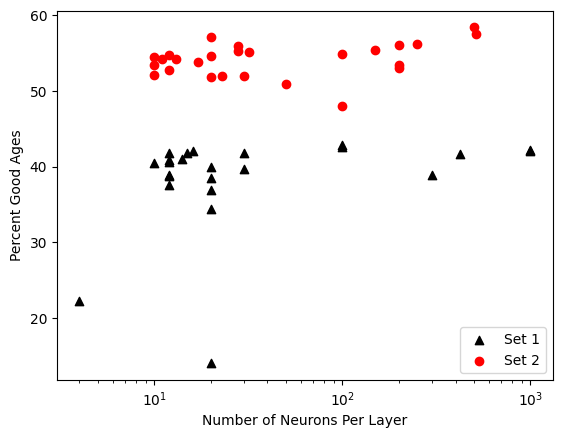

In [31]:
plt.scatter( fitresults['neurons'][train1],fitresults['good'][train1], c='k', marker='^', label='Set 1')
plt.scatter( fitresults['neurons'][train2],fitresults['good'][train2], c='r', label='Set 2')
#plt.xlim(0.,14.)
#plt.plot([0.,14.], [0.,14.])
#plt.plot([14,0,14], [14*(1-metric), 0, 14*(1+metric)])
plt.xscale('log')
plt.xlabel(r'Number of Neurons Per Layer')
plt.ylabel(r'Percent Good Ages')
#plt.ylim(0,14)
plt.legend(loc='lower right')

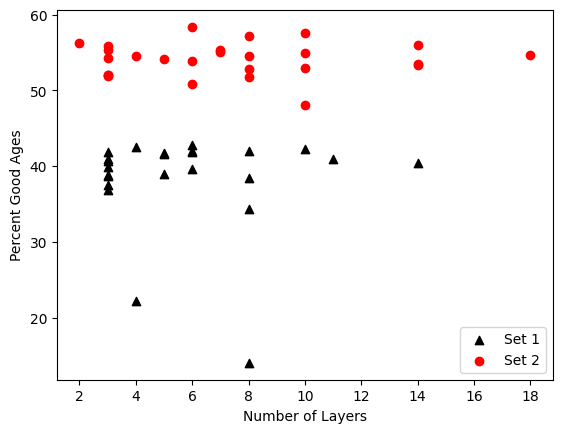

In [32]:
plt.scatter( fitresults['layers'][train1],fitresults['good'][train1], c='k', marker='^', label='Set 1')
plt.scatter( fitresults['layers'][train2],fitresults['good'][train2], c='r', label='Set 2')
#plt.xlim(0.,14.)
#plt.plot([0.,14.], [0.,14.])
#plt.plot([14,0,14], [14*(1-metric), 0, 14*(1+metric)])

plt.xlabel(r'Number of Layers')
plt.ylabel(r'Percent Good Ages')
#plt.ylim(0,14)
plt. legend(loc='lower right')

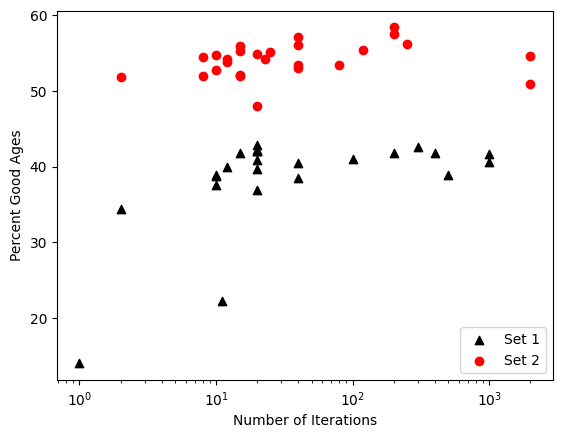

In [33]:
plt.scatter( fitresults['iterations'][train1],fitresults['good'][train1], c='k', marker='^', label='Set 1')
plt.scatter( fitresults['iterations'][train2],fitresults['good'][train2], c='r', label='Set 2')
#plt.xlim(0.,14.)
#plt.plot([0.,14.], [0.,14.])
#plt.plot([14,0,14], [14*(1-metric), 0, 14*(1+metric)])
plt.xscale('log')
plt.xlabel(r'Number of Iterations')
plt.ylabel(r'Percent Good Ages')#plt.ylim(0,14)
plt.legend(loc='lower right')

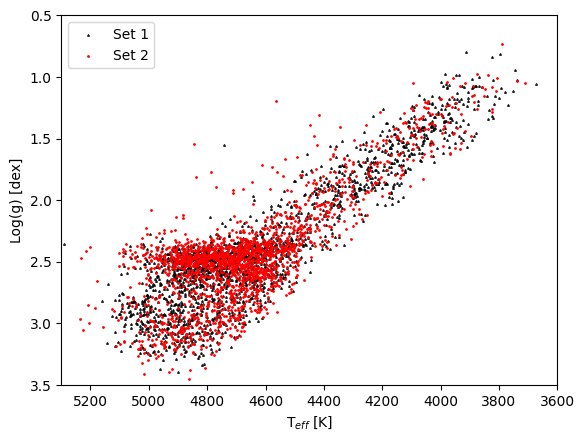

In [34]:
testing1=slice(-2001,-1)
testing2=slice(0,2000)
tfull=fullx[:,0]*scaling_x[0]
loggfull=fullx[:,1]*scaling_x[1]

plt.scatter( tfull[testing1],loggfull[testing1], c='k', marker='^', s=1, label='Set 1')
plt.scatter(  tfull[testing2],loggfull[testing2], c='r', s=1, label='Set 2')
#plt.xlim(0.,14.)
#plt.plot([0.,14.], [0.,14.])
#plt.plot([14,0,14], [14*(1-metric), 0, 14*(1+metric)])

plt.xlabel(r'T$_{eff}$ [K]')
plt.ylabel(r'Log(g) [dex]')
plt.xlim(5300,3600)
plt.ylim(3.5,0.5)
plt.legend()

#plt.ylim(0,14)

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(1.03000000e-04,  74.285408, 3234.5747 ),
     (8.32000000e-04, -19.413851, 2294.9001 ),
     (1.33500000e-03,  57.61953 ,  762.9458 ), ...,
     (3.59996744e+02,  56.16333 , 2739.8916 ),
     (3.59997887e+02, -73.716454, 7217.628  ),
     (3.59999181e+02,  15.477974,  485.76892)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [( 0.04858199,   0.5222485 , 17.408659),
     (20.290022  , -10.34126   , 24.573051),
     (-0.41027406,  -3.2266014 , 28.498526), ...,
     (-1.9080034 ,   0.92653733, 18.3066  ),
     ( 0.45370704,  -1.4541928 , 16.09429 ),
     (28.069422  ,  -3.3527296 , 27.948532)]>

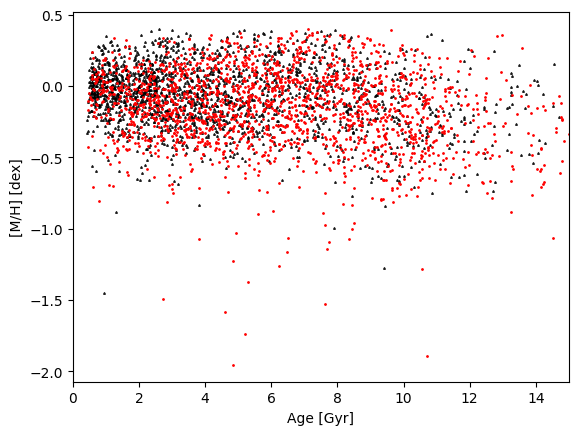

In [35]:
metfull=fullx[:,2]*scaling_x[2]
cfull=fullx[:,3]*scaling_x[3]
nfull=fullx[:,4]*scaling_x[4]
agefull=fully*scaling_y

plt.scatter( agefull[testing1], metfull[testing1], c='k', marker='^', s=1, label='Set 1')
plt.scatter( agefull[testing2], metfull[testing2], c='r', s=1, label='Set 2')
#plt.xlim(0.,14.)
#plt.plot([0.,14.], [0.,14.])
#plt.plot([14,0,14], [14*(1-metric), 0, 14*(1+metric)])

plt.ylabel(r'[M/H] [dex]')
plt.xlabel(r'Age [Gyr]')
plt.xlim(0, 15)
#plt.ylim(3.5,0.5)
c

#plt.ylim(0,14)

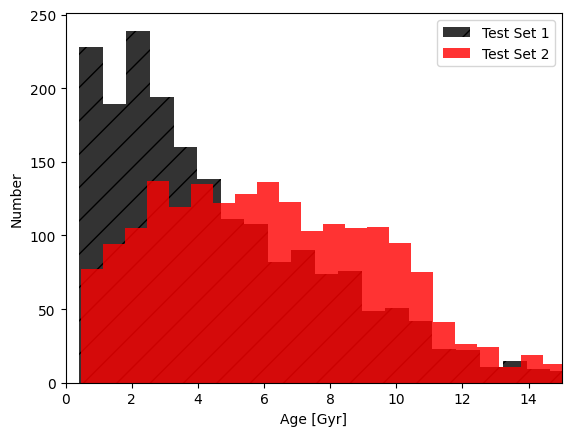

In [36]:
#plt.scatter( agefull[testing1], metfull[testing1], c='k', marker='^', s=1, label='Set 1')
#plt.scatter( agefull[testing2], metfull[testing2], c='r', s=1, label='Set 2')

plt.hist( agefull[testing1].ravel(), bins=100,  color='k', alpha=0.8, hatch='/', label='Test Set 1') #, bins=np.linspace(0, 65536, 1000))
plt.hist( agefull[testing2].ravel(), bins=100,  color='r', alpha=0.8, label='Test Set 2')

plt.ylabel(r'Number')
plt.xlabel(r'Age [Gyr]')
plt.xlim(0, 15)
plt.legend()

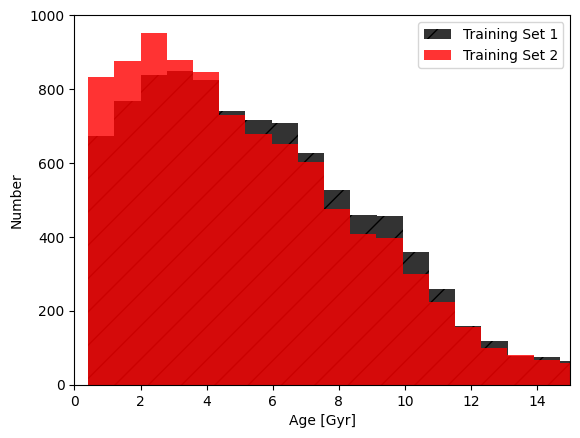

In [37]:
trainingslice1=slice(0,-2002)
trainingslice2=slice(2001,-1)


plt.hist( agefull[trainingslice1].ravel(), bins=100,  color='k', alpha=0.8, hatch='/', label='Training Set 1') #, bins=np.linspace(0, 65536, 1000))
plt.hist( agefull[trainingslice2].ravel(), bins=100,  color='r', alpha=0.8, label='Training Set 2')

plt.ylabel(r'Number')
plt.xlabel(r'Age [Gyr]')
plt.xlim(0, 15)
plt.legend()